In [1]:
import pandas as pd
import os

# Define the directory paths
People = "dataset/1"
Not_People = "dataset/0"

# Function to create DataFrame from directory path
def directory_to_dataframe(directory):
    files = os.listdir(directory)
    df = pd.DataFrame(files, columns=['filename'])
    df['filepath'] = directory + '/' + df['filename']
    return df

# Convert directories to DataFrames
df_people = directory_to_dataframe(People)
df_not_people = directory_to_dataframe(Not_People)

# Print shapes of the DataFrames
print("Shape of People DataFrame:", df_people.shape)
print("Shape of Not_People DataFrame:", df_not_people.shape)



Shape of People DataFrame: (559, 2)
Shape of Not_People DataFrame: (362, 2)


In [2]:
# Combine both DataFrames
df_combined = pd.concat([df_people, df_not_people], ignore_index=True)

# Print the shape of the combined DataFrame
print("Shape of Combined DataFrame:", df_combined.shape)

Shape of Combined DataFrame: (921, 2)


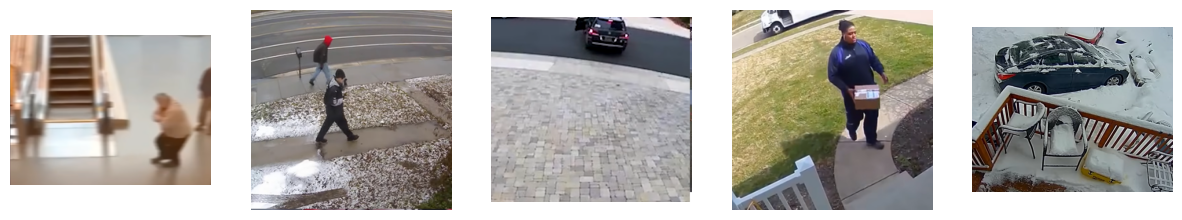

In [3]:
# Function to display random images from DataFrame
import random
import matplotlib.pyplot as plt
from PIL import Image 

def display_random_images(dataframe, num_images):
    random_indices = random.sample(range(len(dataframe)), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, idx in enumerate(random_indices):
        img = Image.open(dataframe.loc[idx, 'filepath'])
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

# Display 5 random images from the combined DataFrame
display_random_images(df_combined, 5)

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Function to load and preprocess images
def load_and_preprocess_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".png"):  # Check if file is PNG
            img = load_img(os.path.join(directory, filename), target_size=(224, 224))
            img = img_to_array(img)
            img = np.expand_dims(img, axis=0)
            img = tf.keras.applications.vgg16.preprocess_input(img)
            images.append(img)
    return np.vstack(images)

# Load and preprocess images from People and Not_People directories
people_images = load_and_preprocess_images(People)
not_people_images = load_and_preprocess_images(Not_People)

# Create labels for the images (1 for people, 0 for not people)
people_labels = np.ones(len(people_images))
not_people_labels = np.zeros(len(not_people_images))

# Combine images and labels
X = np.vstack((people_images, not_people_images))
y = np.hstack((people_labels, not_people_labels))

# Split dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Print shapes of datasets
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of y_test:", y_test.shape)



Shape of X_train: (552, 224, 224, 3)
Shape of X_val: (184, 224, 224, 3)
Shape of X_test: (185, 224, 224, 3)
Shape of y_train: (552,)
Shape of y_val: (184,)
Shape of y_test: (185,)


In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load pre-trained VGG16 model (excluding the top dense layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint("vgg16_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7236 - loss: 7.2459
Epoch 1: val_accuracy improved from -inf to 0.85326, saving model to vgg16_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.7251 - loss: 7.2491 - val_accuracy: 0.8533 - val_loss: 4.9934
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8954 - loss: 4.1987
Epoch 2: val_accuracy improved from 0.85326 to 0.88587, saving model to vgg16_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.8951 - loss: 4.1970 - val_accuracy: 0.8859 - val_loss: 2.3973
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9454 - loss: 1.5757
Epoch 3: val_accuracy did not improve from 0.88587
35/35 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.9456 - loss: 1.5625 - val_accuracy: 0.8641 - val_loss: 2.0200
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9577 - loss: 0.2737
Epoch 4: val_accuracy did not improve from 0.88587
35/35 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - a

In [83]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(30, 30), xy_overlap=(0.1, 0.1), offset=0):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0 #(img.shape[0]*2//3)+20
#         print((img.shape[0]//2)-100)
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    window_list = []

    
    scales=[1,1.5,2,2.5]
    ystart=y_start_stop[0]
    for scale in scales:
        over_x= xy_overlap[0]
        over_y= xy_overlap[1]
        width= xy_window[0]*scale
        height= xy_window[1]*scale
        c= y_start_stop[0]
        
        for row in range(2):
            col=0
            endx=0
            image_width= img.shape[1]
            
            while(endx<image_width):
                
                startx = x_start_stop[0]+ col*width*(1-over_x)
                endx = startx + width
                starty = ystart+ row*height*(1-over_y)
                endy = starty + height
                if(endx-startx==endy-starty and endx-startx!=0):
#                     print(endx-startx, endy-starty)
                    window_list.append(((int(startx), int(starty)), (int(endx), int(endy)), width/64.0))
                col+=1
#         y_start_stop[0]-=5    
    return window_list

In [10]:
def preprocessImage(img_array):
    img = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.vgg16.preprocess_input(img)
    
img = load_img(os.path.join('dataset/1', '0.png'), target_size=(224, 224))
test_image_array = img_to_array(img)
test_image = preprocessImage(test_image_array)
window_list = slide_window(img)

AttributeError: 'Image' object has no attribute 'shape'

In [73]:
import cv2 as cv2

def draw_boxes(img, bboxes, color=(255, 0, 0), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        print(bbox)
#         print(bbox[2])
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        point=(bbox[0][0],bbox[0][1]-20)
        text= str(bbox[2])
        cv2.putText(imcopy,text,point, cv2.FONT_HERSHEY_SIMPLEX, 0.4,(255,0,0),1,cv2.LINE_AA)
    # Return the image copy with boxes drawn
    return imcopy

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def detect(img, windows):
    imageCopy= np.copy(img)
    """Classify all windows within img."""
    #t = Timer()
    imageCopy= np.copy(img)
    human_windows = []
    last_ratio=0
    for window in windows:
        window_image = img[window[0][1]: window[1][1]+(window[1][1]-window[0][1]), window[0][0]: window[1][0]+(window[1][0]-window[0][0])]
        window_image = cv2.resize(window_image, (224, 224))
        preprocessed_image = preprocessImage(window_image)
        prediction = model.predict(preprocessed_image,verbose = 0)
        if(prediction[0] > 0.99999):
            human_windows.append(window)
    return human_windows



In [8]:
from scipy.ndimage.measurements import label
def draw_objects(coords, draw_img):
    out_image = np.zeros((720,1280,3), dtype=np.uint8)
    index=1
    out_image[0:720,0:1280,:] = cv2.resize(draw_img,(1280,720)) 
    offset_left=30
    offset_start=30
    mid_gap=40
    
    for coord in coords:
        if(index<4):
            x_start= coord[0][0]
            y_start= coord[0][1]
            x_end= coord[1][0]
            y_end= coord[1][1]
            if x_end-x_start>70 and y_end-y_start>50:
                aspect_ratio= float(x_end-x_start)/(y_end-y_start)

                detected_image = np.zeros((150,220,3), dtype=np.uint8)
                if(aspect_ratio>=0.8 and aspect_ratio<=4):
                    detected_image= cv2.resize(draw_img[y_start+5:max(y_end-5,y_start+80),x_start+5:max(x_end-5,x_start+115)],(220,150))
                    cv2.rectangle(out_image,(offset_left-2,offset_start-2),(offset_left+222,offset_start+152 ), (255,0,0), 3)
                else:
                    cv2.putText(detected_image,'Bad Quality ',(50,80), cv2.FONT_HERSHEY_SIMPLEX, 0.7,(255,0,0),2,cv2.LINE_AA)
                    cv2.rectangle(out_image,(offset_left-2,offset_start-2),(offset_left+222,offset_start+152 ), (255,0,0), 3)
                cv2.rectangle(out_image, coord[0], coord[1], (255,0,0), 2)
                out_image[offset_start:offset_start+150,offset_left:offset_left+220,:] = cv2.resize(detected_image,(220,150))
                cv2.putText(out_image,'Human '+str(index)+' detected',(offset_left,offset_start-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6,(255,0,0),2,cv2.LINE_AA)
                offset_start+=150+mid_gap
        index+=1
    return out_image
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    coord=[]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        point=(np.min(nonzerox), np.min(nonzeroy)-20)
        text= 'Car '+ str(car_number)
#         cv2.putText(img,text,point, cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0,255,0),2,cv2.LINE_AA)
        # Draw the box on the image
        aspect_ratio= float(bbox[1][0]-bbox[0][0])/(bbox[1][1]-bbox[0][1])
        if(aspect_ratio>=0.8 ):
            
            coord.append((bbox[0], bbox[1]))
    # Return the image
    return img, coord


/var/folders/1d/tqxf7wg949d9cffwxmfhx68r0000gn/T/ipykernel_10218/1555911573.py:1: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [28]:
# img = load_img(os.path.join('dataset/1', '0.png'), target_size=(224, 224))
image = cv2.imread('test_human_walking.jpg')

draw_image = np.copy(image)
print(draw_image.shape)
windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(100, 100), xy_overlap=(0.5,0.5), offset=50)

#     print(len(windows))
hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
window_img= cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB)

(720, 1280, 3)


NameError: name 'search_windows' is not defined

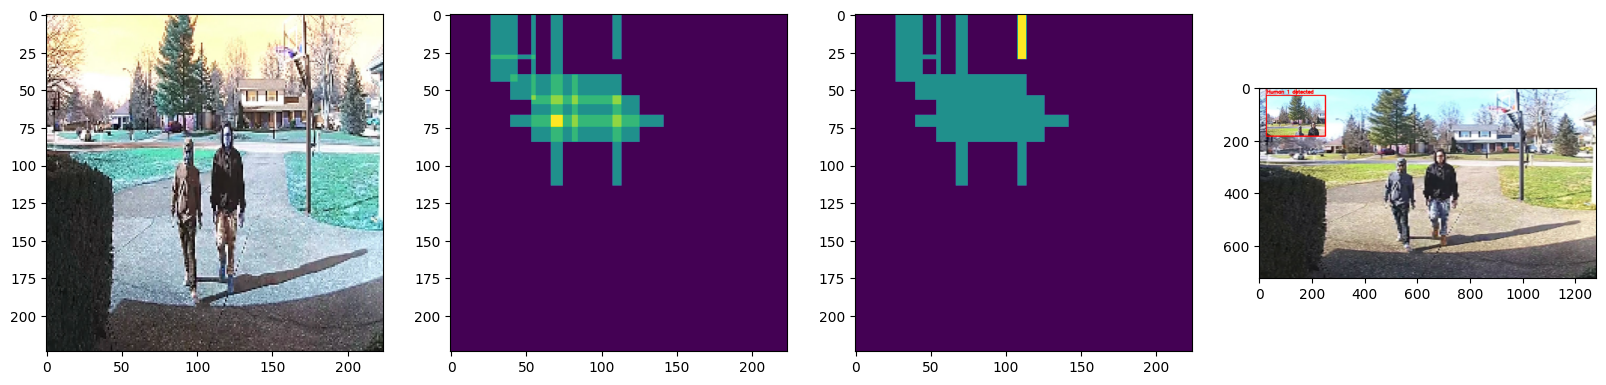

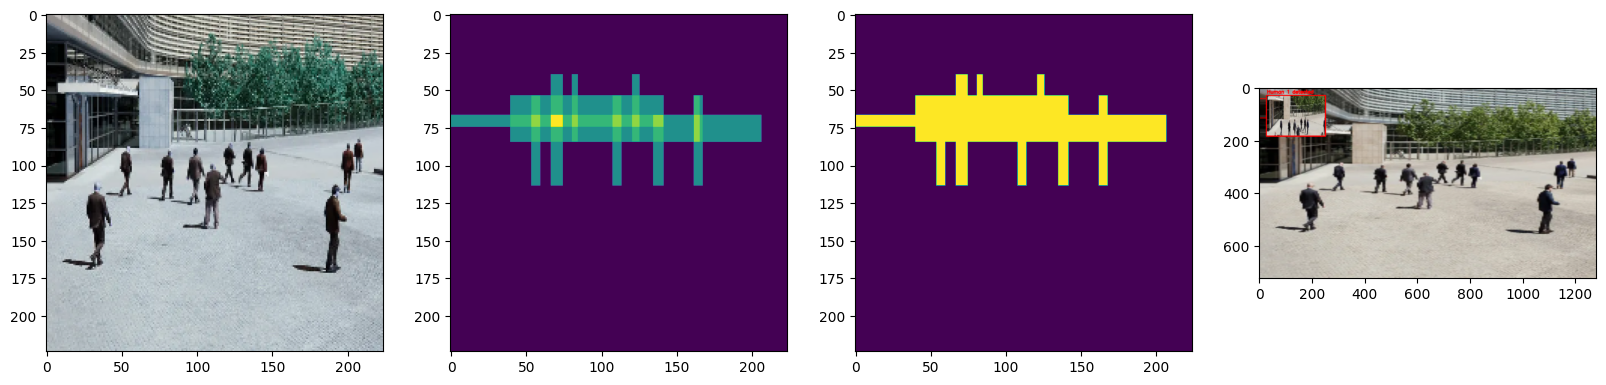

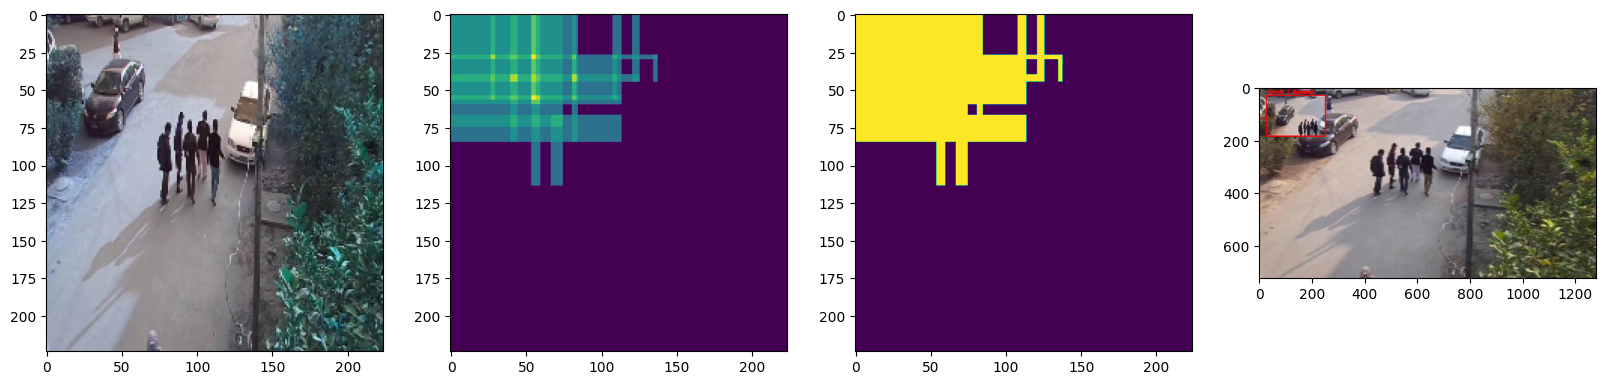

In [84]:
def pipeline(image):
    f,axes= plt.subplots(1,4, figsize=(20,5))
    image = cv2.resize(image, (224, 224))
    axes[0].imshow(image)
    window_list = slide_window(image)
    human_windows = detect(image, window_list)
    heat = np.zeros_like(image[:,:,0]).astype(np.float64)
    heat = add_heat(heat,human_windows)
    heat = apply_threshold(heat,2) 
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    axes[1].imshow(heatmap)
    axes[2].imshow(labels[0])
    # plt.imshow(labels[0])
    draw_img,coord = draw_labeled_bboxes(np.copy(image), labels)
    
    drawn = draw_objects(coord, cv2.cvtColor(draw_img,cv2.COLOR_BGR2RGB))
    
    axes[3].imshow(drawn)
    return drawn
image_0= cv2.imread('test_human_walking_0.jpg')
image_1 = cv2.imread('test_human_walking_1.jpg')
image_2 = cv2.imread('test_human_walking_2.jpg')
a = pipeline(image_0)
a = pipeline(image_1)
a = pipeline(image_2)
# plt.imshow(a)
# video_output1 = 'project_video_output.mp4'
# video_input1 = cv2.VideoCapture('project-video.mp4')
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# out = cv2.VideoWriter( 
#         "output.avi", cv2.VideoWriter_fourcc(*'MPEG'), 2, (224, 224)) 
# success,image = video_input1.read()
# count = 0
# while (count < 1):
#     count+=1
#     print("frame: ", count)
#     frame = pipeline(image)
    
#     # plt.imshow(frame)
#     out.write(frame)
# video_input1.release()
# out.release
# cv2.destroyAllWindows() 

In [13]:
out.release

<function VideoWriter.release>

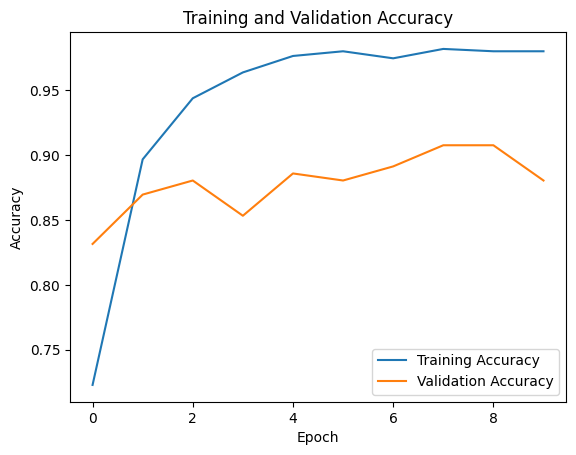

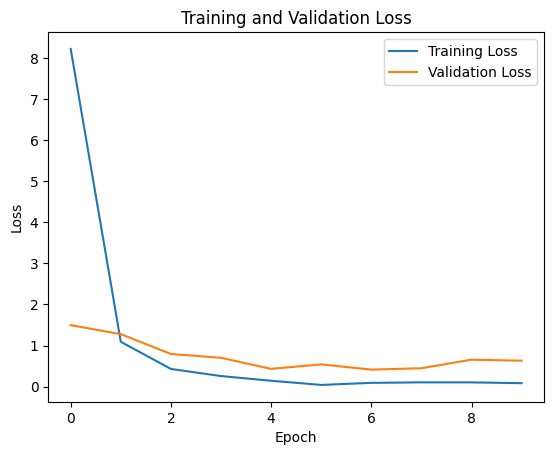

In [15]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [240]:
# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[15:]:
    layer.trainable = True

# Compile the model again after unfreezing layers
model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define callbacks for model checkpoint and early stopping
checkpoint = ModelCheckpoint("vgg16_fine_tuned_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)

# Fine-tune the model
history_fine_tuned = model.fit(X_train, y_train,
                                batch_size=16,
                                epochs=10,
                                validation_data=(X_val, y_val),
                                callbacks=[checkpoint, early_stopping])

# Evaluate the fine-tuned model on the test set
test_loss_fine_tuned, test_acc_fine_tuned = model.evaluate(X_test, y_test)
print('Test loss (fine-tuned):', test_loss_fine_tuned)
print('Test accuracy (fine-tuned):', test_acc_fine_tuned)


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.9521 - loss: 0.2581
Epoch 1: val_accuracy improved from -inf to 0.84783, saving model to vgg16_fine_tuned_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 26s 727ms/step - accuracy: 0.9523 - loss: 0.2582 - val_accuracy: 0.8478 - val_loss: 0.9701
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.9714 - loss: 0.1661
Epoch 2: val_accuracy did not improve from 0.84783
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 702ms/step - accuracy: 0.9710 - loss: 0.1699 - val_accuracy: 0.8478 - val_loss: 0.5427
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.9792 - loss: 0.0592
Epoch 3: val_accuracy improved from 0.84783 to 0.89674, saving model to vgg16_fine_tuned_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9791 - loss: 0.0593 - val_accuracy: 0.8967 - val_loss: 0.3729
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.9959 - loss: 0.0236
Epoch 4: val_accuracy improved from 0.89674 to 0.91304,

In [241]:
import random

# Concatenate the DataFrames
df_combined = pd.concat([df_people, df_not_people], ignore_index=True)

# Randomly select an image path from the combined DataFrame
random_row = random.choice(range(len(df_combined)))
random_image_path = df_combined.loc[random_row, 'filepath']

# Now you can use this random_image_path for testing


In [242]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

# Function to preprocess a single image
def preprocess_single_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

# Preprocess the randomly selected image
preprocessed_image = preprocess_single_image(random_image_path)

# Now, you can use this preprocessed_image for testing with your model
# For example, if your model is named 'model', you can make predictions as follows:
# predictions = model.predict(preprocessed_image)
# Then, you can interpret the predictions to determine if the image contains a person or not


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


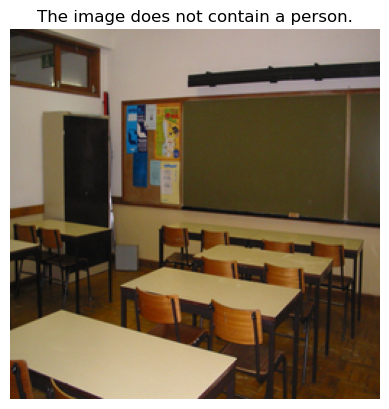

In [261]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

# Function to preprocess a single image
def preprocess_single_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

# Function to display image and prediction result
def display_image_with_prediction(image_path, prediction):
    img = load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    if prediction > 0.5:
        plt.title("The image contains a person.")
    else:
        plt.title("The image does not contain a person.")
    plt.show()

# Select a random image path from the dataset
random_row = random.choice(range(len(df_combined)))
random_image_path = df_combined.loc[random_row, 'filepath']

# Preprocess the randomly selected image
preprocessed_image = preprocess_single_image(random_image_path)

# Make predictions using your trained model
predictions = model.predict(preprocessed_image)

# Display the image and prediction result
display_image_with_prediction(random_image_path, predictions[0])
